In [350]:
import pandas as pd
import media_mapper as mm
import numpy as np
from sklearn.cluster import KMeans
import json
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

In [258]:
###get dataframe
df = mm.pipeline.retrieve_sql_tweets('tweets_with_geoV6')

In [259]:
df.head()

,timestamp_ms,geoid10,id
0,1436990735491,060750615003006,621410300290592768
1,1437945824772,060750134001000,625416235082194944
2,1438041259509,060759804011003,625816517381332992
3,1437873474604,060750101001001,625112776483188736
4,1437929054749,060750604001007,625345896507666432


##get a count for every day of the week, and hour of the day

In [267]:
#obtain hour and day of week variables
df  =mm.pipeline.transform_timestamp(df, hour = True, DOW = True)

In [261]:
df.shape

(95840, 7)

In [5]:
def tweet_rate_by_hour(df, dow = False):
    '''Calculates tweets per hour from a dataframe with unqiue entries for tweets, 
    and a datetime column. Drops the id column.
    If dow is false, will return a dataframe grouped only by hour. 
    If dow is true, will return a dataframe grouped by weekend(0) or weekday (1).'''
    #column of ones serves as a counter for number of tweets during group bys
    df['twt_cnt'] = 1
    #group by hour, so we have the total tweets for every hour
    df = df.groupby(['geoid10', 'date', 'hour']).agg(np.sum).reset_index().drop('id', 1)
    #At this point, the twt_count is the number of tweets for every hour 
    df['twt_rate'] = df['twt_cnt']
    if dow == False:
        #groupby geoid and hour to get the average rate for every hour
        df = df.groupby(['geoid10', 'hour']).agg(np.mean).reset_index()
        df.drop('DOW', 1, inplace = True)
        df.drop('twt_cnt', 1, inplace = True )  
        df['hr_bin'] = pd.cut(df.hour, bins = 5, labels = ['latenight', 'dawn','morning','afternoon','evening'])
        df = df.groupby(['geoid10', 'hr_bin']).agg(np.mean).reset_index().drop('hour', 1)
        return df
    if dow == True:
        #group by date for the average tweet rate every day
        df = df.groupby(['geoid10', 'date', 'DOW']).agg(np.mean).reset_index()
        df.drop('hour',1, inplace = True)
        df.drop('twt_cnt',1, inplace = True)    
        df['wknd']=df['DOW'].where(df['DOW'] > 5) 
        df['wkday'] = df['wknd'].isnull().astype(int)
        df.drop('DOW', 1, inplace = True)
        df.drop('wknd', 1, inplace = True)
        #final groupby to get an average count for week days or weekends 
        df = df.groupby(['geoid10', 'wkday']).agg(np.mean).reset_index()
        return df
    return df

In [6]:
def pivot_table(df, timevariable, column_prefix ):
    '''Takes a dataframe with three columns: Geoid, measurement of tweets, and time variable.
    Takes an argument of a column_prefix, which is used to name the new time variable columns.
    Pivots the table to create a dataframe with geoid as the index, and the time variable as the features.
    '''
    df = df.pivot(index = 'geoid10', columns = timevariable)
    df = df.reset_index(1)
    df = df.rename(columns = lambda x: column_prefix + str(x))
    df.columns = df.columns.droplevel()
    return df

In [7]:
#get tweet rate by hour
df_tr_wkdy = tweet_rate_by_hour(df, dow= True)
#pivot table so DOW is columns
df_tr_wkdy = pivot_table(df_tr_wkdy, 'wkday', column_prefix = 'wkday_')

In [8]:
df_tr_wkdy.tail()

wkday,wkd_,wkd_0,wkd_1
3790,060759809001128,1.0,1.083333
3791,060759809001129,NaN,1.000000
3792,060759809001134,1.0,1.000000
3793,060759901000002,1.0,NaN
3794,060759901000003,2.5,NaN


In [9]:
#get tweet rate by hour
df_tr_hr = tweet_rate_by_hour(df)
#pivot table so time of day is columns
df_tr_hr = pivot_table(df_tr_hr, 'hr_bin', column_prefix = 'hrbin_')

###merge dataframes for one matrix

In [181]:
dfk = pd.merge(df_tr_hr, df_tr_wkdy, left_on = 'hrbin_', right_on = 'wkd_').drop('wkd_', 1)
#fill missing values with zeroes 
dfk.fillna(0, inplace = True)

###Run k means

In [184]:
k_array = dfk[['hrbin_afternoon','hrbin_dawn',
 'hrbin_evening',
 'hrbin_latenight',
 'hrbin_morning',
 'wkd_0',
 'wkd_1']].values

In [16]:
kmeans2 = KMeans(n_clusters = 6)
kmeans.fit(X =k_array )
features = dfk.columns.tolist()[1:]
geoids = dfk['hrbin_']

# 3. Find the top 10 features for each cluster.

In [23]:
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
print "top features for each cluster:"
for num, centroid in enumerate(top_centroids):
    print num
    print centroid
    print "%d: %s" % (num, ", ".join(features[i] for i in centroid))

top features for each cluster:
0
[5 3 2 6 0 1 4]
0: wkd_0, hrbin_latenight, hrbin_evening, wkd_1, hrbin_afternoon, hrbin_dawn, hrbin_morning
1
[3 1 2 4 0 5 6]
1: hrbin_latenight, hrbin_dawn, hrbin_evening, hrbin_morning, hrbin_afternoon, wkd_0, wkd_1
2
[6 2 3 0 5 1 4]
2: wkd_1, hrbin_evening, hrbin_latenight, hrbin_afternoon, wkd_0, hrbin_dawn, hrbin_morning
3
[5 2 3 1 0 4 6]
3: wkd_0, hrbin_evening, hrbin_latenight, hrbin_dawn, hrbin_afternoon, hrbin_morning, wkd_1
4
[2 0 5 3 6 4 1]
4: hrbin_evening, hrbin_afternoon, wkd_0, hrbin_latenight, wkd_1, hrbin_morning, hrbin_dawn
5
[5 2 3 1 0 6 4]
5: wkd_0, hrbin_evening, hrbin_latenight, hrbin_dawn, hrbin_afternoon, wkd_1, hrbin_morning


###put geoids and cluster into a dictionary for storage

In [26]:
from collections import defaultdict
geoidclust = defaultdict(int)
clusters = defaultdict(list)
assigned_cluster = kmeans.transform(k_array).argmin(axis=1)
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, k_array.shape[0])[assigned_cluster==i]
    geoids = [dfk.ix[geoindx]['hrbin_'] for geoindx in cluster]
    print len(geoids), 'cluster #', i
    #make a dictionary of cluster as the key, and geoids as the list
    clusters[i] = geoids
    #second dictionary to quickly look up what cluster each geoid belongs to
    for geo in geoids:
        geoidclust[geo] = i
   

1582 cluster # 0
1 cluster # 1
2094 cluster # 2
1 cluster # 3
1 cluster # 4
116 cluster # 5


In [ ]:
#save my clusters to a dictionary. i like them.

In [347]:
ls

create_feature_matrix_tweetrate.py   processes_df.py
create_feature_matrix_tweetrate.pyc  sql_tweet_process.py
data/                                tessstttyyy.png
k_means_cluster_test.ipynb           tfidif.ipynb
kmeans_round1_clustdict.csv          token_testing.ipynb
kmeans_round1_geodict.csv            tokenizer.pyc
make_shapes.py                       twitter_data_to_sql.ipynb*
map_making/                          twitter_data_to_sql.py
nmf_clustering.ipynb                 unsupervised_clustering.py


In [346]:
import csv

with open('kmeans_round1_clustdict.csv', 'wb') as f:  # Just use 'w' mode in 3.x
    w = csv.DictWriter(f, clusters.keys())
    w.writeheader()
    w.writerow(clusters)

###How do they Map?

In [28]:
#add geocolumn 
dfk['geoid10'] = dfk['hrbin_']
#add tweetcount as average value
dfk['tweetcnt'] = dfk[['hrbin_afternoon',
 'hrbin_dawn',
 'hrbin_evening',
 'hrbin_latenight',
 'hrbin_morning',
 'wkd_0',
 'wkd_1']].mean(axis = 1)

In [39]:
def merge_shapes_with_dataframe(df):
    '''imports sql shape files for san francisco. Adds them to a dataframe based on the shared 'geoid10' column.
    Also assmes a 'tweetcnt' column. Returns the new dataframe'''
    ###Retrieve the Shape Files for Each Block:
    geodf = pd.read_csv('/Users/christy/Documents/root/repos/media_mapper/data_pipeline/data/intermediate_data/sf_only_sql_shapes.csv')
    #format the dataframe
    geodf['geoid10'] = geodf.geoid10.astype('str')
    geodf.drop('Unnamed: 0', axis = 1, inplace = True)
    
    df['geoid10'] =df['geoid10'].apply(lambda x: x[1:])
    #create a new dataframe 
    df = pd.merge(geodf, df, on='geoid10', how='outer')
    #fill no tweets with a zero value
    df.tweetcnt.fillna(0, inplace = True)
    #drop empty hour columns
    return df


In [41]:
#format geocolumn for mergind 
dfk['geoid10'] =dfk['geoid10'].apply(lambda x: x[1:])
geodf = merge_shapes_with_dataframe(dfk)
#optional color pallet
colors = ['#c6f50f', '#66cdaa', '#ffa500', '#f67453', '#f6c653', '#ab9eba']
#add color column based on values 
mapdf['hexcolor'] =mapdf["hrbin_"].apply(lambda x:colors[geoidclust[x]].upper())
mapdf['cluster'] = mapdf['hrbin_'].apply(lambda x: str(geoidclust[x]))


In [115]:
#right now I am not using the cluster color 

def add_properties_geo(row):
    '''Creates the properties geoid, tweetcnt, cluster number'''
    geoid = row['geoid10']
    tweetrate = row['tweetcnt']
    hexcolor = row['hexcolor']
    cluster = row['cluster']
    geo_json = {"type": "Feature", "geometry": json.loads(row['geometry']), "properties": {'geoid': geoid ,'tweetrate': tweetrate, 'cluster': cluster , 'hexcolor' : hexcolor}}
    return geo_json

def dataframe_to_geojson(df, outfilename):
    '''Takes in a dataframe with a count, geoid10, and list of tokens. Dumps it into a json geojason file'''
    df['geoid10'] = df['geoid10'].astype('str')
    df["tweetcnt"] = df['tweetcnt'].astype('str')
    list_to_export = []
    for idx, row in df.iterrows():
        list_to_export.append(add_properties_geo(row))
    with open(outfilename, 'w') as outfile:
        json.dump(list_to_export, outfile)

In [117]:
dataframe_to_geojson(mapdf, 'map_making/clusters/data/clustergeo.json')

/Users/christy/miniconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/christy/miniconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### what did it cluster on?

####Round 1:

In [140]:
clusters[1]

['060759804011003']

In [137]:
for k, v in clusters.iteritems():
    print k,'\n number of neighborhoods: ', len(v), '\n', dfk[dfk['hrbin_'].isin(v)].mean(),'\n','\n'

0 
 number of neighborhoods:  1582 
hrbin_afternoon    1.043457
hrbin_dawn         0.750566
hrbin_evening      1.074981
hrbin_latenight    1.096141
hrbin_morning      0.491886
wkd_0              1.605076
wkd_1              1.067310
dtype: float64 


1 
 number of neighborhoods:  1 
hrbin_afternoon    83.581667
hrbin_dawn         86.952941
hrbin_evening      84.998214
hrbin_latenight    88.728333
hrbin_morning      84.970588
wkd_0              82.623853
wkd_1              62.680556
dtype: float64 


2 
 number of neighborhoods:  2094 
hrbin_afternoon    0.421302
hrbin_dawn         0.189490
hrbin_evening      0.483564
hrbin_latenight    0.447790
hrbin_morning      0.163801
wkd_0              0.244269
wkd_1              0.943002
dtype: float64 


3 
 number of neighborhoods:  1 
hrbin_afternoon    15.402857
hrbin_dawn         25.400000
hrbin_evening      32.708571
hrbin_latenight    30.120000
hrbin_morning       1.416667
wkd_0              40.571429
wkd_1               1.000000
dtype: flo

wait. so how are these three clusters different?

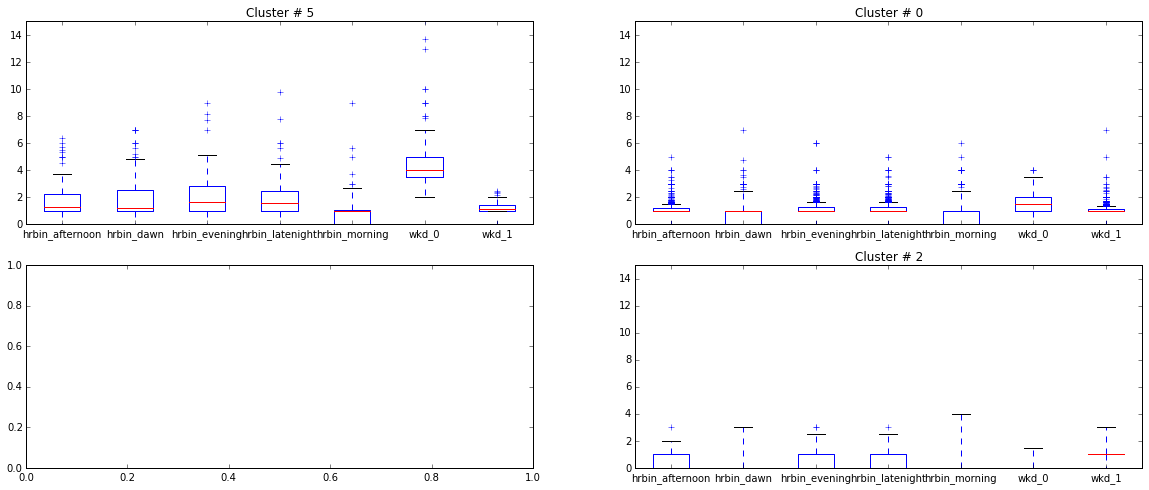

In [180]:
fig, axes = plt.subplots(nrows=2, ncols=2)
cluster5 = clusters[5]
dfk[dfk['hrbin_'].isin(cluster5)].plot(kind = 'box', title = 'Cluster # 5', figsize = (20,8),ylim = (0,15),ax=axes[0,0])

cluster5 = clusters[0]
dfk[dfk['hrbin_'].isin(cluster5)].plot(kind = 'box', title = 'Cluster # 0', figsize = (20,8), ylim = (0,15), ax=axes[0,1])

cluster5 = clusters[2]
dfk[dfk['hrbin_'].isin(cluster5)].plot(kind = 'box', title = 'Cluster # 2', figsize = (20,8), ylim = (0,15), ax=axes[1,1])

##Rerun. Took out outlier in golden gate. Determined K with Silouette Coeffecient.

In [269]:
#take out the outlier of the bridge. Also take out the two weird places.

nogg = df[(df['geoid10']!= '060759803001030')]
gg = df[(df['geoid10']== '060759803001030')]
ggdf = pd.concat([nogg, gg[(gg['time'].dt.day > 10) | (gg['time'].dt.month < 8)]])
ggdf = ggdf[(ggdf['geoid10']!= '060759803001030')]


def clean_and_run_kmeans(df):
    '''takes a dataframe. Does cleaning of the dataframe, and then calls the function run_k_means. 
    Returns a three part tuple with the kmeans model, and two dictionaries of geoides and clusters '''
    #get tweet rate by hour
    ggdow = tweet_rate_by_hour(ggdf, dow= True)
    #pivot table so DOW is columns
    ggdow = pivot_table(ggdow, 'wkday', column_prefix = 'wkday_')
    #get tweet rate by hour
    gghr = tweet_rate_by_hour(ggdf)
    #pivot table so time of day is columns
    gghr = pivot_table(gghr, 'hr_bin', column_prefix = 'hrbin_')
    ggkmeans = pd.merge(gghr, ggdow, left_on = 'hrbin_', right_on = 'wkday_').drop('wkday_', 1)
    #fill missing values with zeroes 
    ggkmeans.fillna(0, inplace = True)
    answer = run_k_means(ggkmeans, 8)
    return answer 

In [334]:
def run_k_means(df, numberclusters, geoidlabel ='hrbin_' ):
    '''Uses sklearn to run kmeans. Takes a dataframe with a geoid column (geoidlabel column name). 
    Accepts argument for number of clusters to find.
    Returns a three part tuple.
    1) the kmeans sklearn model
    2) a dictionary with geoids as the key, and the cluster as the value
    3) a dictionary with clusters as the key, and a list of related geoids as the value'''
    #model a new k means
    x = df[['hrbin_afternoon','hrbin_dawn',
     'hrbin_evening',
     'hrbin_latenight',
     'hrbin_morning',
     'wkday_0',
     'wkday_1']].values
    kmeans = KMeans(n_clusters = numberclusters)
    kmeans.fit(X =x )
    features = df.columns.tolist()[1:]
    geoids = df[geoidlabel]
    
    #store values in a dictionary
    #store them in a dictionary for me! 
    geoid_dict = defaultdict(int)
    cluster_dict = defaultdict(list)
    assigned_cluster = kmeans.transform(x).argmin(axis=1)
    for i in range(kmeans.n_clusters):
        cluster = np.arange(0, x.shape[0])[assigned_cluster==i]
        geoids = [df.ix[geoindx]['hrbin_'] for geoindx in cluster]
        print len(geoids), 'cluster #', i
        #make a dictionary of cluster as the key, and geoids as the list
        cluster_dict[i] = geoids
        #second dictionary to quickly look up what cluster each geoid belongs to
        for geo in geoids:
            geoid_dict[geo] = i
    return (kmeans, geoid_dict, cluster_dict)

In [368]:
kmeans2,geoid_dict2,  cluster_dict2 = run_k_means(ggkmeans, 8)
   

804 cluster # 0
1 cluster # 1
1097 cluster # 2
610 cluster # 3
1 cluster # 4
836 cluster # 5
44 cluster # 6
402 cluster # 7


In [ ]:
kmeans2,geoid_dict2,  cluster_dict2 = run_k_means(ggkmeans, 8)

####Check Number of Clusters for K Means with Silouette Score

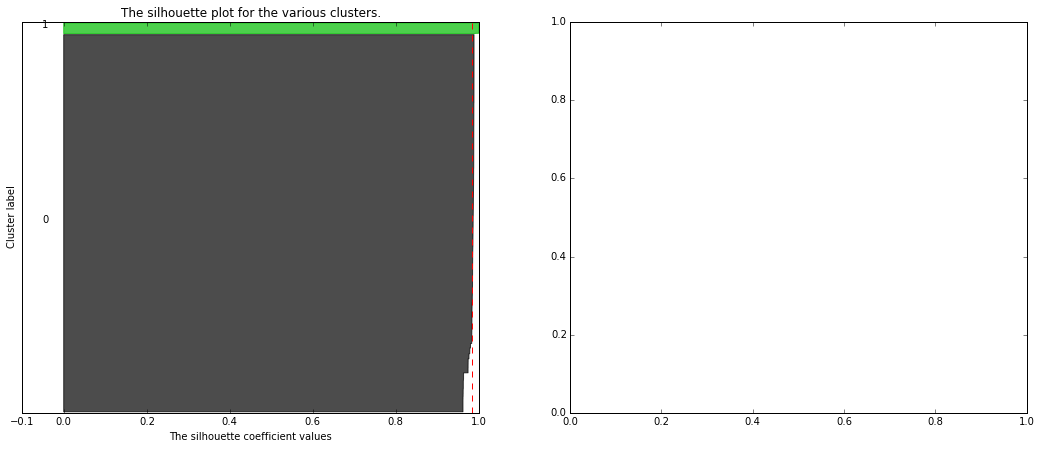

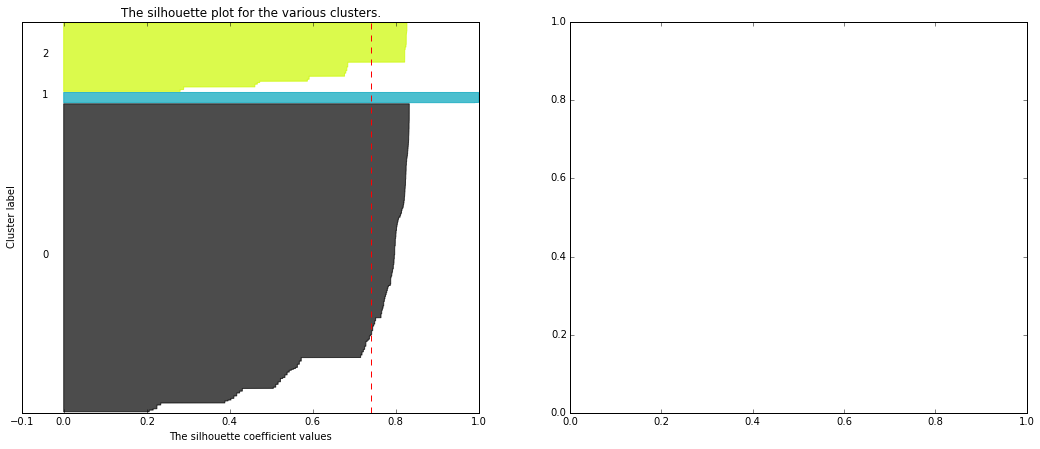

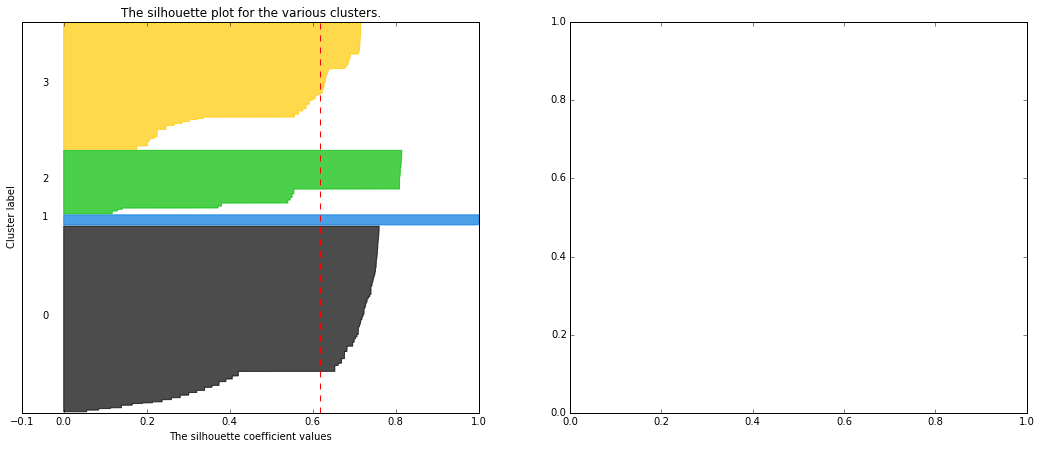

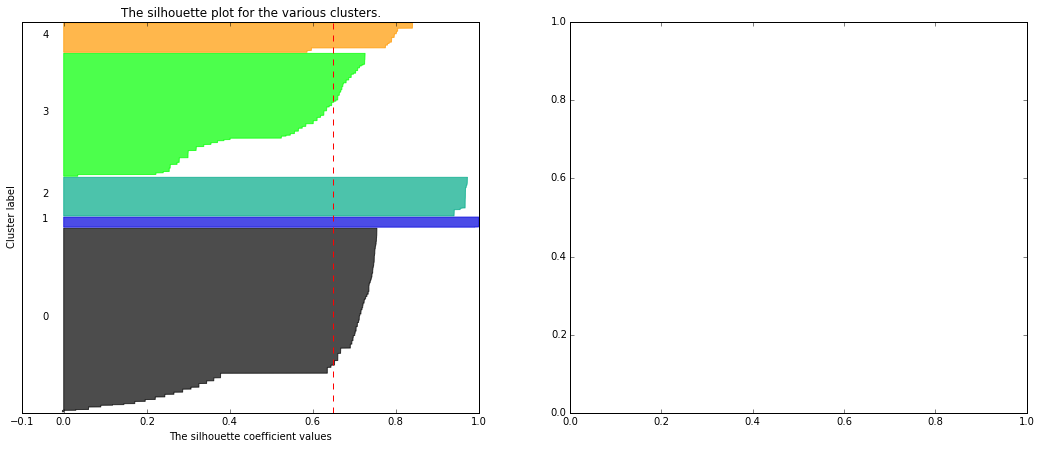

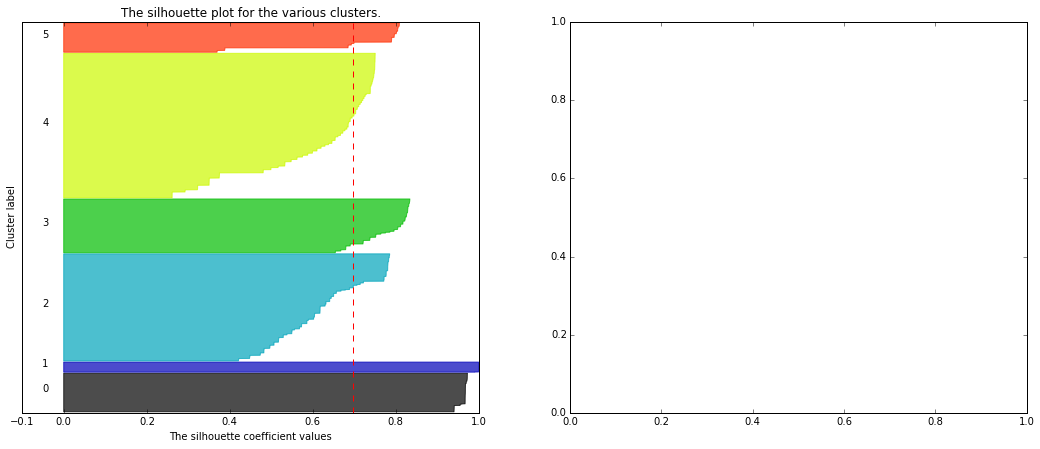

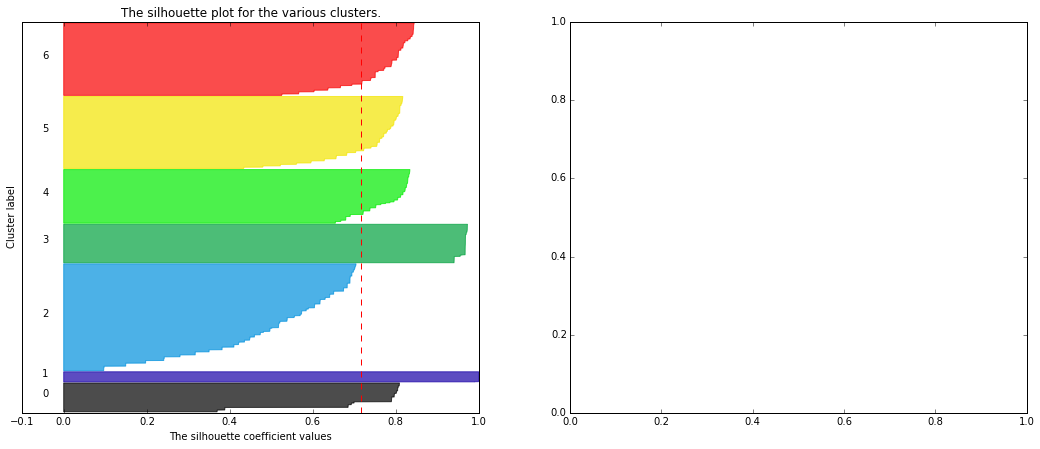

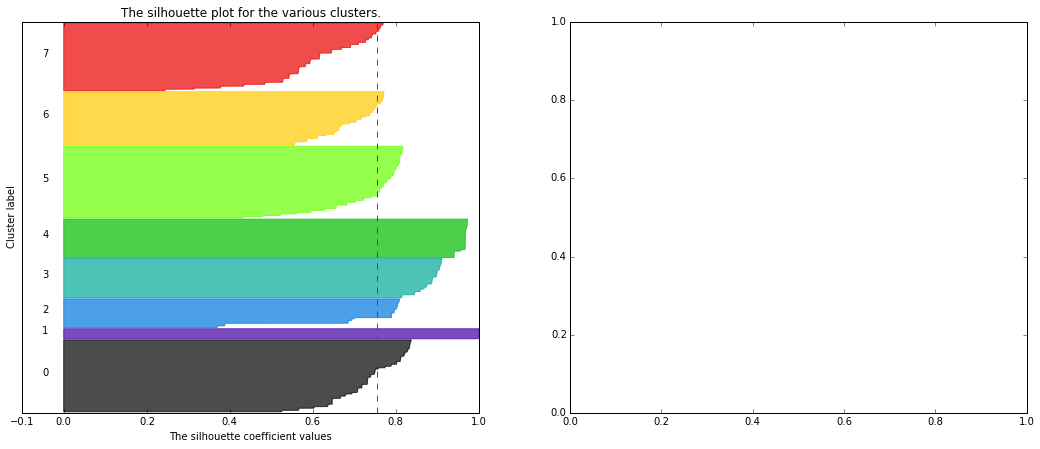

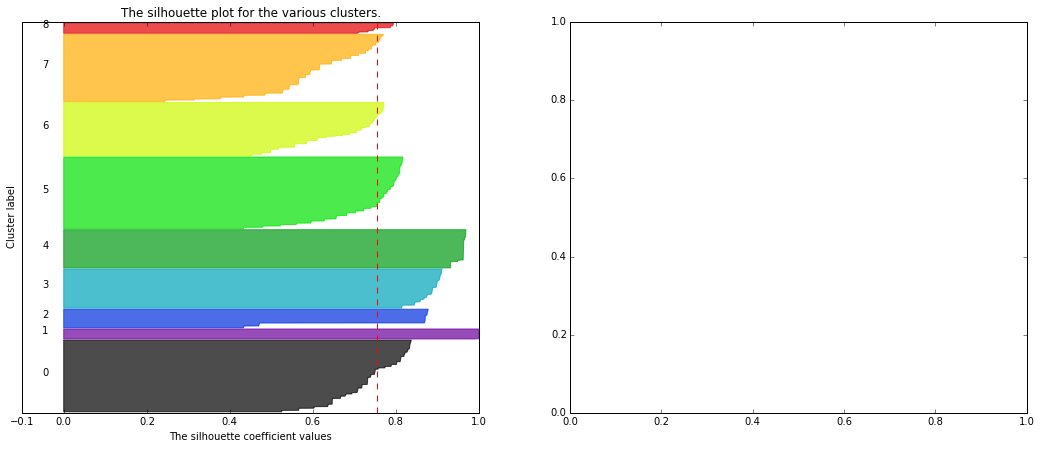

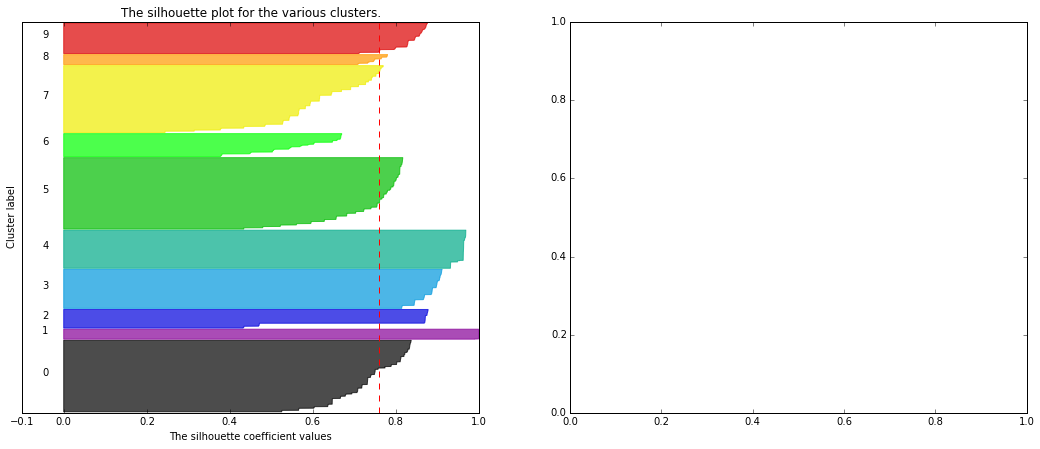

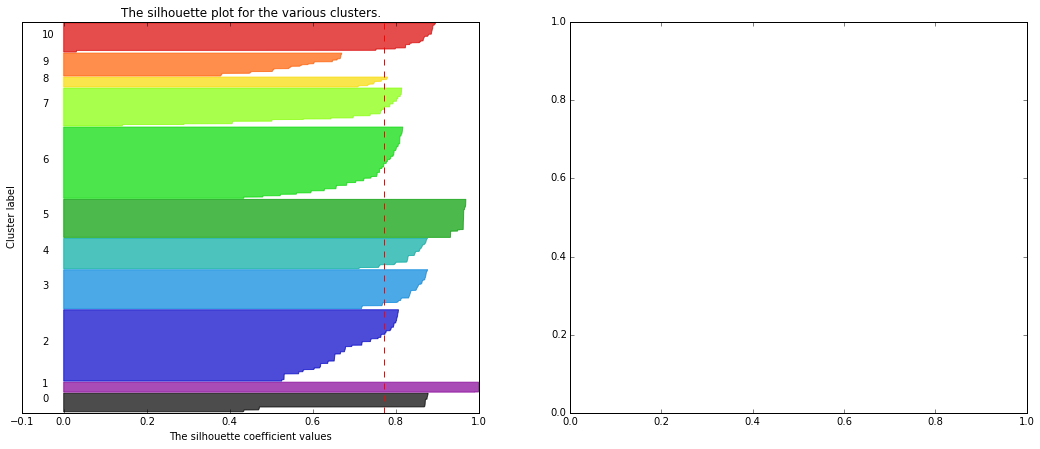

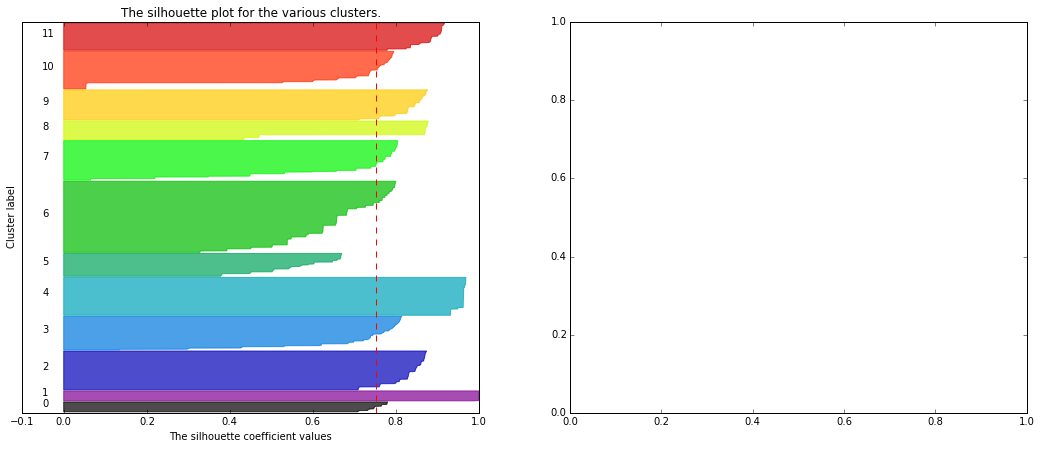

In [366]:
'''From Sklearn: Silhoette coefficients (as these values are referred to as) 
near +1 indicate that the sample is far away from the neighboring clusters. 
A value of 0 indicates that the sample is on or very close to the decision boundary 
between two neighboring clusters and negative values indicate that those samples might 
have been assigned to the wrong cluster.'''

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
X = ggkmeans
clusternum = []
silouettescore = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    clusternum.append(n_clusters)
    silouettescore.append(silhouette_avg)
    #print "For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

   
    plt.show()

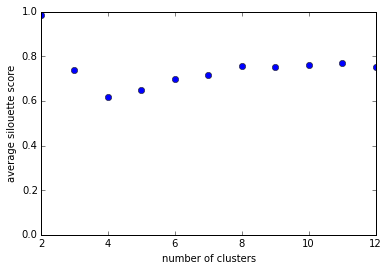

In [367]:

plt.plot(clusternum, silouettescore, 'o')
plt.ylim(0, 1)
plt.xlabel('number of clusters')
plt.ylabel('average silouette score')

In [ ]:
#6 or 8 